In [3]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer      #experimental api
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder,StandardScaler,power_transform
from sklearn.model_selection import train_test_split
import xgboost as xgb
from scipy.stats import boxcox
from sklearn.linear_model import BayesianRidge

In [5]:
data=pd.read_csv('datasets/train.csv')
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1200000 non-null  int64  
 1   Age                   1181295 non-null  float64
 2   Gender                1200000 non-null  object 
 3   Annual Income         1155051 non-null  float64
 4   Marital Status        1181471 non-null  object 
 5   Number of Dependents  1090328 non-null  float64
 6   Education Level       1200000 non-null  object 
 7   Occupation            841925 non-null   object 
 8   Health Score          1125924 non-null  float64
 9   Location              1200000 non-null  object 
 10  Policy Type           1200000 non-null  object 
 11  Previous Claims       835971 non-null   float64
 12  Vehicle Age           1199994 non-null  float64
 13  Credit Score          1062118 non-null  float64
 14  Insurance Duration    1199999 non-

In [6]:
categorical_data=data.select_dtypes(include=['object'])
numerical_data=data.select_dtypes(exclude=['object'])
# print(categorical_data.info())
# print(numerical_data.info())

In [7]:
cat_col=[]
num_col=[]
for i in data.columns:
    if data[i].dtype=='object':
        cat_col.append(i)
    else:
        num_col.append(i)

# print('categorical col: '+str(cat_col))
# print('numerical col: '+str(num_col))


In [8]:
data["Policy Start Date"]=pd.to_datetime(data["Policy Start Date"])

data["year"]=data["Policy Start Date"].dt.year
data["month"]=data["Policy Start Date"].dt.month
data["day"]=data["Policy Start Date"].dt.day

data.drop("Policy Start Date",axis=1,inplace=True)

In [9]:
num_col.append("year")
num_col.append("month")
num_col.append("day")
cat_col.remove("Policy Start Date")

skewness: 1.2409154932891036
<class 'pandas.core.series.Series'>


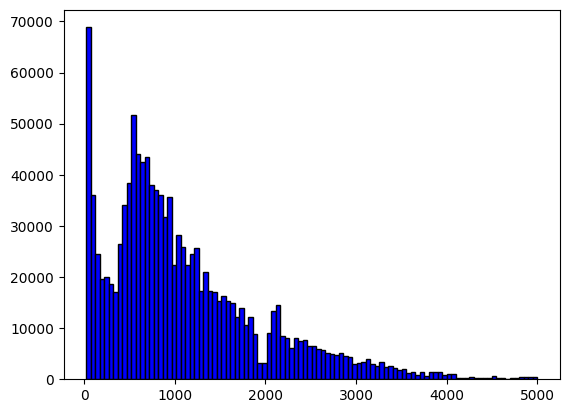

In [83]:
skewness=data["Premium Amount"].skew()
print('skewness: '+str(skewness))
print(type(data["Premium Amount"]))
import matplotlib.pyplot as plt

plt.hist(data["Premium Amount"],bins=100,color='blue',edgecolor='black')
plt.show()

In [ ]:
y=power_transform(data["Premium Amount"].values.reshape(-1,1),method='yeo-johnson')
y.reshape(1200000,)
skewness=y.skew()
print('skewness: '+str(skewness))
plt.hist(y,bins=100,color='blue',edgecolor='black')
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'skew'

In [10]:
# num_inputer=SimpleImputer(strategy='mean')
cat_inputer=SimpleImputer(strategy='most_frequent')

# train_data[num_col]=num_inputer.fit_transform(train_data[num_col])
data[cat_col]=cat_inputer.fit_transform(data[cat_col])

# print(train_data.isnull().sum())

imputer=IterativeImputer()
data[num_col]=imputer.fit_transform(data[num_col])


In [11]:
encoder=OneHotEncoder(sparse_output=False,handle_unknown='ignore')
# for i in cat_col:
#   if(i in train_data.columns):
#       print(i)
for i in cat_col:
  # print(i)
  encoded_value=encoder.fit_transform(data[[i]])
  encoded_value=pd.DataFrame(encoded_value,columns=encoder.get_feature_names_out([i]))
  data.drop(i,axis=1,inplace=True)
  data=pd.concat([data,encoded_value],axis=1)

In [12]:
# y=np.log1p(data["Premium Amount"])
num=data.columns
scaler=StandardScaler()
data[num]=scaler.fit_transform(data[num])

In [57]:
print((train_data["Premium Amount"] < 0).sum())  

734809


In [58]:
correration_matrix=train_data.corr()
# print(correration_matrix)

In [ ]:
# print(correration_matrix["Premium Amount"])
# data.drop("id",axis=1,inplace=True)

In [60]:
print(train_data["Premium Amount"].isnull().sum())
print((train_data["Premium Amount"] < 0).sum())  

0
734809


In [13]:
train_X,valid_X,train_y,valid_y=train_test_split(data.drop("Premium Amount",axis=1),data["Premium Amount"],test_size=0.2,random_state=0)
# print(train_X.info())
# print(train_y.info())

In [14]:
valid_X.drop("id",axis=1,inplace=True)
train_X.drop("id",axis=1,inplace=True)

Now implement a regressor

In [27]:
best_params = {
    'colsample_bytree': 0.7,
    'learning_rate': 0.01,
    'max_depth': 15,
    'n_estimators': 500,
    'subsample': 0.8,
    'reg_alpha': 0.001,
    'reg_lambda': 100,
}

model=xgb.XGBRegressor(**best_params)

In [28]:
model.fit(train_X,train_y)
# predictions=model.predict(train_X)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=15, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [30]:
accuracy=model.score(train_X,train_y)
print('train accuracy: '+str(accuracy))

train accuracy: 0.4452547456849859


In [31]:
# prediction_valid=model.predict(valid_X)
val_accuracy=model.score(valid_X,valid_y)
print(val_accuracy)

0.3428952082631844


In [66]:
test_data=pd.read_csv('datasets/test.csv')
print(test_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    800000 non-null  int64  
 1   Age                   787511 non-null  float64
 2   Gender                800000 non-null  object 
 3   Annual Income         770140 non-null  float64
 4   Marital Status        787664 non-null  object 
 5   Number of Dependents  726870 non-null  float64
 6   Education Level       800000 non-null  object 
 7   Occupation            560875 non-null  object 
 8   Health Score          750551 non-null  float64
 9   Location              800000 non-null  object 
 10  Policy Type           800000 non-null  object 
 11  Previous Claims       557198 non-null  float64
 12  Vehicle Age           799997 non-null  float64
 13  Credit Score          708549 non-null  float64
 14  Insurance Duration    799998 non-null  float64
 15  

In [67]:
categorical_data_test=test_data.select_dtypes(include=['object'])
numerical_data_test=test_data.select_dtypes(exclude=['object'])

cat_col_test=[]
num_col_test=[]
for i in test_data.columns:
    if test_data[i].dtype=='object':
        cat_col_test.append(i)
    else:
        num_col_test.append(i)
        

In [68]:
test_data["Policy Start Date"]=pd.to_datetime(test_data["Policy Start Date"])
test_data["year"]=test_data["Policy Start Date"].dt.year
test_data["month"]=test_data["Policy Start Date"].dt.month
test_data["day"]=test_data["Policy Start Date"].dt.day

test_data.drop("Policy Start Date",axis=1,inplace=True)


In [69]:
cat_col_test.remove("Policy Start Date")
num_col_test.append("year")
num_col_test.append("month")
num_col_test.append("day")

In [70]:
test_data[cat_col_test]=cat_inputer.fit_transform(test_data[cat_col_test])

test_data[num_col_test]=imputer.fit_transform(test_data[num_col_test])

In [71]:
for col in cat_col_test:
  encoded_value=encoder.fit_transform(test_data[[col]])
  encoded_value=pd.DataFrame(encoded_value,columns=encoder.get_feature_names_out([col]))
  test_data.drop(col,axis=1,inplace=True)
  test_data=pd.concat([test_data,encoded_value],axis=1)

In [73]:
num_test=test_data.columns
test_data[num_test]=scaler.fit_transform(test_data[num_test])

In [74]:
X_test=test_data.drop("id",axis=1)

In [ ]:
predictions=model.predict(X_test)

In [ ]:

prediction=np.expm1(predictions)
result=pd.DataFrame({"id":train_data["id"],"Premium Amount":prediction})
result.to_csv("results/prediction.csv",index=False)